In [1]:
from math import log
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
%matplotlib inline
import matplotlib.pyplot as plt
from pycbc.types.frequencyseries import FrequencySeries
from pycbc.cosmology import redshift, cosmological_quantity_from_redshift
from pycbc.detector import Detector
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform.utils import taper_timeseries, td_taper
from pycbc.filter.matchedfilter import sigma
from pycbc.psd.read import from_txt
from tqdm import tqdm

In [2]:
def strain_generator(det='ET-D', signal_type='BBH', model='IMRPhenomD', fs=4096, df=None,
                     flow=2, fref=2, tc=0, params=None, fd_taper=False, rotation=False, domain='frequency'):

    if domain == 'time':
        if signal_type == "BBH":
            # Generate a waveform at the detector-frame.
            hp, hc = get_td_waveform(approximant=model, 
                        mass1=params['mass1'], mass2=params['mass2'],
                        spin1x=params['spin1x'], spin1y=params['spin1y'],
                        spin1z=params['spin1z'], spin2x=params['spin2x'],
                        spin2y=params['spin2y'], spin2z=params['spin2z'],
                        distance=params['distance'], coa_phase=params['coa_phase'],
                        inclination=params['inclination'], f_lower=flow,
                        f_ref=fref, delta_t=1.0/fs)

        elif signal_type in ["NSBH", "BNS"]:
            # Generate a waveform at the detector-frame.
            hp, hc = get_td_waveform(approximant=model, 
                        mass1=params['mass1'], mass2=params['mass2'],
                        spin1z=params['spin1z'],
                        spin2z=params['spin2z'],
                        distance=params['distance'], coa_phase=params['coa_phase'],
                        inclination=params['inclination'], f_lower=flow,
                        f_ref=fref, delta_t=1.0/fs)

        else:
            raise ValueError("`signal_type` must be chosen from ['BBH', 'BNS', 'NSBH'].")

        # Set merger time to 'tc'.
        hp.start_time += tc
        hc.start_time += tc

        # Project GW waveform onto GW detectors.
        ra = params['ra']
        dec = params['dec']
        psi = params['polarization']
        time = hp.start_time

        if det == 'ET-D':
            det_1 = Detector("E1")
            det_2 = Detector("E2")
            det_3 = Detector("E3")
            num_detectors = 3
        elif det == 'CE':  #  Assume same position and orientation as aLIGO.
            det_1 = Detector("H1")
            det_2 = Detector("L1")
            num_detectors = 2
        else:
            raise NotImplementedError("No such detector.")

        fp_1, fc_1 = det_1.antenna_pattern(
                        right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
        fp_2, fc_2 = det_2.antenna_pattern(
                        right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
        if num_detectors == 3:
            fp_3, fc_3 = det_3.antenna_pattern(
                            right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)

        if rotation == True:
            # Take the rotation of the earth into account by using the "project_wave" function.
            ht_1 = det_1.project_wave(hp=hp, hc=hc, ra=ra, dec=dec, polarization=psi)
            ht_2 = det_2.project_wave(hp=hp, hc=hc, ra=ra, dec=dec, polarization=psi)
            ht_list = [ht_1, ht_2]
            if num_detectors == 3:
                ht_3 = det_3.project_wave(hp=hp, hc=hc, ra=ra, dec=dec, polarization=psi)
                ht_list.append(ht_3)
        else:
            # Not take the rotation of the earth into account.
            ht_1 = fp_1*hp + fc_1*hc
            ht_2 = fp_2*hp + fc_2*hc
            ht_list = [ht_1, ht_2]
            if num_detectors == 3:
                ht_3 = fp_3*hp + fc_3*hc
                ht_list.append(ht_3)

        return ht_list

    else:
        if signal_type == "BBH":
            sptilde, sctilde = get_fd_waveform(approximant=model, 
                                    mass1=params['mass1'], mass2=params['mass2'],
                                    spin1x=params['spin1x'], spin1y=params['spin1y'],
                                    spin1z=params['spin1z'], spin2x=params['spin2x'],
                                    spin2y=params['spin2y'], spin2z=params['spin2z'],
                                    distance=params['distance'], coa_phase=params['coa_phase'],
                                    inclination=params['inclination'], f_lower=flow,
                                    f_ref=fref, delta_f=df)
        elif signal_type in ["NSBH", "BNS"]:
            sptilde, sctilde = get_fd_waveform(approximant=model, 
                                    mass1=params['mass1'], mass2=params['mass2'],
                                    spin1z=params['spin1z'],
                                    spin2z=params['spin2z'],
                                    distance=params['distance'], coa_phase=params['coa_phase'],
                                    inclination=params['inclination'], f_lower=flow,
                                    f_ref=fref, delta_f=df)
        else:
            raise ValueError("`signal_type` must be chosen from ['BBH', 'BNS', 'NSBH'].")

        return FrequencySeries(sptilde, delta_f=df, epoch=None)


def optimal_snr(strain, fs, psd_path, flow, taper=False, is_asd_file=True, domain='frequency'):
    if domain == 'time':
        td_length = strain.duration
        delta_f = 1.0/td_length
        if taper == False:
            strain_freq = strain.to_frequencyseries(delta_f)
        else:
            strain_freq = taper_timeseries(strain, tapermethod='TAPER_STARTEND').to_frequencyseries(delta_f)
        N = int(td_length*fs)
        fd_length = int(N/2 + 1)
        psd = from_txt(filename=psd_path, length=fd_length, delta_f=delta_f, low_freq_cutoff=flow, is_asd_file=is_asd_file)
    else:
        psd = from_txt(filename=psd_path, length=len(strain), delta_f=strain.delta_f, low_freq_cutoff=flow, is_asd_file=is_asd_file)
        strain_freq = strain
    snr_opt = sigma(htilde=strain_freq, psd=psd, low_frequency_cutoff=flow, high_frequency_cutoff=fs/2)        
    return snr_opt


def horizon_distance(det='ET-D', signal_type='BBH', model='IMRPhenomD', psd_path=None, is_asd_file=True, fs=4096, df=1./100,
                     flow=2, fref=2, tc=1126259462.0, params=None, snr_threshold=8, rotation=False, taper=False, domain='frequency'):

    if det == 'ET-D':
        ave_ra = 0
        ave_dec = 0
        for detector_name in ['E1', 'E2', 'E3']:
            detector = Detector(detector_name)
            ra, dec = detector.optimal_orientation(t_gps=tc)
            ave_ra += ra
            ave_dec += dec
        ra, dec = ave_ra/3, ave_dec/3
    elif det == 'CE':
        detector_name = 'H1'
        detector = Detector(detector_name)
        ra, dec = detector.optimal_orientation(t_gps=tc)
    else:
        raise NotImplementedError("No such detector.")

    params['ra'] = ra
    params['dec'] = dec
    input_redshift = redshift(params['distance'])
    params['mass1'] = params['srcmass1'] * (1+input_redshift)
    params['mass2'] = params['srcmass2'] * (1+input_redshift)

    strain = strain_generator(det=det, signal_type=signal_type, model=model, fs=fs, df=df,
                              flow=flow, fref=fref, tc=tc, params=params, rotation=rotation, domain=domain)

    if det == 'CE':
        if domain == 'time':
            input_snr = optimal_snr(strain=strain[0], fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
        else:
            input_snr = optimal_snr(strain=strain, fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
        input_distance = params['distance']
        guess_snr = 0
        n_steps = 0

        # Recursively evaluate the true horizon distance.
        while np.abs(guess_snr-snr_threshold) >= snr_threshold*0.0001 and n_steps < 10:
            try:
                factor_rescale = input_snr/snr_threshold
                guess_distance = input_distance*factor_rescale
                guess_redshift = redshift(guess_distance)
                # Update the detector-frame masses and the luminosity distance.
                params['mass1'] = params['srcmass1'] * (1+guess_redshift)
                params['mass2'] = params['srcmass2'] * (1+guess_redshift)
                params['distance'] = guess_distance
                strain = strain_generator(det=det, signal_type=signal_type, model=model, fs=fs, df=df,
                                          flow=flow, fref=fref, tc=tc, params=params, rotation=rotation, domain=domain)
                if domain == 'time':
                    guess_snr = optimal_snr(strain=strain[0], fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
                else:
                    guess_snr = optimal_snr(strain=strain, fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
                input_snr = guess_snr
                input_redshift = guess_redshift
                input_distance = guess_distance
                n_steps += 1
            except:
                n_steps = 10

        # Interpolation method.
        if n_steps == 10:
            # print("Not converge, now use the interpolation method.")
            redshift_array = np.linspace(0.05, 100, 100)  # CMB's redshift is about 1063.
            snr_array = []
            for z in redshift_array:
                params['mass1'] = params['srcmass1'] * (1+z)
                params['mass2'] = params['srcmass2'] * (1+z)
                params['distance'] = cosmological_quantity_from_redshift(z, 'luminosity_distance')
                # print('z: ', z)
                strain = strain_generator(det=det, signal_type=signal_type, model=model, fs=fs, df=df,
                                          flow=flow, fref=fref, tc=tc, params=params, rotation=rotation, domain=domain)
                if domain == 'time':
                    snr = optimal_snr(strain=strain[0], fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
                else:
                    snr = optimal_snr(strain=strain, fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
                snr_array.append(snr)
                if snr < snr_threshold*0.5:  # Avoid DL becoming too large for lalsimulation.
                    break
            snr_z_interp = interp1d(snr_array, redshift_array[:len(snr_array)], fill_value='extrapolate')
            guess_redshift = snr_z_interp(snr_threshold)
            guess_distance = cosmological_quantity_from_redshift(guess_redshift, 'luminosity_distance')
            # plt.figure(dpi=150)
            # plt.plot(snr_array, snr_z_interp(snr_array))
            # plt.axvline(snr_threshold, linestyle='dotted')
            # plt.xlabel("SNR")
            # plt.ylabel("redshift")
            # plt.xlim(3, 15)
            # plt.show()

    elif det == 'ET-D':
        network_snr_sq = 0
        for index in range(1):
            if domain == 'time':
                snr = optimal_snr(strain=strain[index], fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
            else:
                snr = optimal_snr(strain=strain, fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
                snr *= np.sqrt(3)/2  # For the frequency-domain, there's no antenna pattern to include the opening angle factor.
        network_snr_sq = 3*snr**2    # Three V-shape detectors.
        input_snr = np.sqrt(network_snr_sq)
        input_distance = params['distance']
        guess_snr = 0
        n_steps = 0

        # Recursively evaluate the true horizon distance.
        while np.abs(guess_snr-snr_threshold) >= snr_threshold*0.0001 and n_steps < 10:
            try:
                factor_rescale = input_snr/snr_threshold
                guess_distance = input_distance*factor_rescale
                guess_redshift = redshift(guess_distance)
                # Update the detector-frame masses and the luminosity distance.
                params['mass1'] = params['srcmass1'] * (1+guess_redshift)
                params['mass2'] = params['srcmass2'] * (1+guess_redshift)
                params['distance'] = guess_distance
                strain = strain_generator(det=det, signal_type=signal_type, model=model, fs=fs, df=df,
                                          flow=flow, fref=fref, tc=tc, params=params, rotation=rotation, domain=domain)
                # Calculate the network optimal SNR.
                network_snr_sq = 0
                for index in range(1):
                    if domain == 'time':
                        snr = optimal_snr(strain=strain[index], fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
                    else:
                        snr = optimal_snr(strain=strain, fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
                        snr *= np.sqrt(3)/2  # For the frequency-domain, there's no antenna pattern to include the opening angle factor.
                network_snr_sq = 3*snr**2
                guess_snr = np.sqrt(network_snr_sq)

                input_snr = guess_snr
                input_redshift = guess_redshift
                input_distance = guess_distance
                n_steps += 1
            except:
                n_steps = 10

        # Interpolation method.
        if n_steps == 10:
            # print("Not converge, now use the interpolation method.")
            redshift_array = np.linspace(0.05, 100, 100)  # CMB's redshift is about 1063.
            snr_array = []
            for z in redshift_array:
                params['mass1'] = params['srcmass1'] * (1+z)
                params['mass2'] = params['srcmass2'] * (1+z)
                params['distance'] = cosmological_quantity_from_redshift(z, 'luminosity_distance')
                strain = strain_generator(det=det, signal_type=signal_type, model=model, fs=fs, df=df,
                                          flow=flow, fref=fref, tc=tc, params=params, rotation=rotation, domain=domain)
                # Calculate the network optimal SNR.
                network_snr_sq = 0
                for index in range(1):
                    if domain == 'time':
                        snr = optimal_snr(strain=strain[index], fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
                    else:
                        snr = optimal_snr(strain=strain, fs=fs, psd_path=psd_path, flow=flow, taper=taper, is_asd_file=is_asd_file, domain=domain)
                        snr *= np.sqrt(3)/2  # For the frequency-domain, there's no antenna pattern to include the opening angle factor.
                network_snr_sq = 3*snr**2
                snr = np.sqrt(network_snr_sq)

                if snr < snr_threshold*0.5:  # Avoid DL becoming too large for lalsimulation.
                    break
                snr_array.append(snr)
            snr_z_interp = interp1d(snr_array, redshift_array[:len(snr_array)], fill_value='extrapolate')
            guess_redshift = snr_z_interp(snr_threshold)
            guess_distance = cosmological_quantity_from_redshift(guess_redshift, 'luminosity_distance')
            # plt.figure(dpi=150)
            # plt.plot(snr_array, snr_z_interp(snr_array))
            # plt.axvline(snr_threshold, linestyle='dotted')
            # plt.xlabel("SNR")
            # plt.ylabel("redshift")
            # plt.xlim(3, 15)
            # plt.show()

    else:
        raise NotImplementedError("No such detector.")

    return guess_distance

[0.0000000e+00 6.2500000e-02 1.2500000e-01 ... 2.0478750e+03 2.0479375e+03
 2.0480000e+03] [1.46456269e-58 3.71071835e-58 4.72955283e-58 ... 5.10796501e-49
 4.95944233e-49 1.47860942e-49]
[1.46456269e-58 3.71071835e-58 4.72955283e-58 ... 5.10796501e-49
 4.95944233e-49 1.47860942e-49]
[0.0000000e+00 6.2500000e-02 1.2500000e-01 ... 2.0478750e+03 2.0479375e+03
 2.0480000e+03] [3.92135997e-56 9.78782663e-56 1.13165906e-55 ... 5.10614068e-49
 4.95927133e-49 1.47943371e-49]
[0.0000000e+00 6.2500000e-02 1.2500000e-01 ... 2.0478750e+03 2.0479375e+03
 2.0480000e+03] [1.02230597e-54 2.19773932e-54 2.30666015e-54 ... 1.31293997e-48
 1.27470181e-48 3.79938917e-49]
[1.02230597e-54 2.19773932e-54 2.30666015e-54 ... 1.31293997e-48
 1.27470181e-48 3.79938917e-49]
[0.0000000e+00 6.2500000e-02 1.2500000e-01 ... 2.0478750e+03 2.0479375e+03
 2.0480000e+03] [1.37699504e-54 3.13650511e-54 3.30834389e-54 ... 1.31314773e-48
 1.27458063e-48 3.79937858e-49]


 88%|████████▊ | 44/50 [25:32<02:38, 26.39s/it]XLAL Error - XLALSimIMRPhenomDGenerateFD (LALSimIMRPhenomD.c:151): (fCut = 3.76963 Hz) <= f_min = 5

XLAL Error - XLALSimIMRPhenomDGenerateFD (LALSimIMRPhenomD.c:151): Input domain error
XLAL Error - XLALSimInspiralChooseFDWaveform (LALSimInspiral.c:1611): Internal function call failed: Input domain error
XLAL Error - XLALSimIMRPhenomDGenerateFD (LALSimIMRPhenomD.c:151): (fCut = 4.94603 Hz) <= f_min = 5

XLAL Error - XLALSimIMRPhenomDGenerateFD (LALSimIMRPhenomD.c:151): Input domain error
XLAL Error - XLALSimInspiralChooseFDWaveform (LALSimInspiral.c:1611): Internal function call failed: Input domain error
 90%|█████████ | 45/50 [25:52<02:03, 24.63s/it]XLAL Error - XLALSimIMRPhenomDGenerateFD (LALSimIMRPhenomD.c:151): (fCut = 4.50496 Hz) <= f_min = 5

XLAL Error - XLALSimIMRPhenomDGenerateFD (LALSimIMRPhenomD.c:151): Input domain error
XLAL Error - XLALSimInspiralChooseFDWaveform (LALSimInspiral.c:1611): Internal function call failed: Inpu

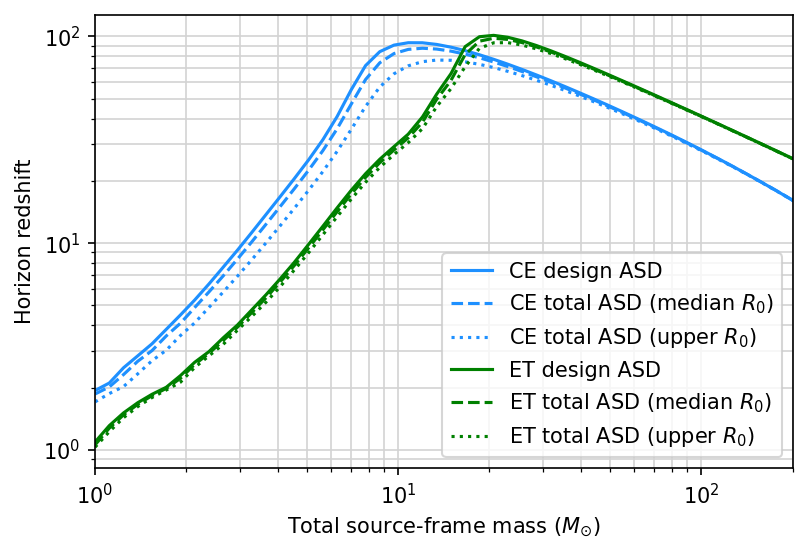

In [3]:
# CE

psd_CE_total_median = pd.read_csv('psd_total_CE_median_512s_16s_5h.csv')
psd_CE_total_median = np.array(psd_CE_total_median).T
total_psd_CE_medianrate = np.mean(psd_CE_total_median[1:], axis=0)
print(psd_CE_total_median[0], total_psd_CE_medianrate)
print(total_psd_CE_medianrate)

file = open("./total_psd_CE_mean_medianrate.txt", 'w')
file.write("# Freq(Hz) \t\t PSD\n")
for i in range(len(psd_CE_total_median[0])):
    file.write("%.18f \t\t %.18e\n" % (psd_CE_total_median[0][i], total_psd_CE_medianrate[i]))
file.close()

psd_CE_total_upper = pd.read_csv('psd_total_CE_upper_512s_16s_5h.csv')
psd_CE_total_upper = np.array(psd_CE_total_upper).T
total_psd_CE_upperrate = np.mean(psd_CE_total_upper[1:], axis=0)
print(psd_CE_total_upper[0], total_psd_CE_upperrate)

file = open("./total_psd_CE_mean_upperrate.txt", 'w')
file.write("# Freq(Hz) \t\t PSD\n")
for i in range(len(psd_CE_total_upper[0])):
    file.write("%.18f \t\t %.18e\n" % (psd_CE_total_upper[0][i], total_psd_CE_upperrate[i]))
file.close()

design_asd_path_CE = "/mnt/d/on-source_psd_correction/detector_network/ASD/CE_asd.txt"
total_psd_path_CE_upperrate = "./total_psd_CE_mean_upperrate.txt"
total_psd_path_CE_medianrate = "./total_psd_CE_mean_medianrate.txt"

# ET-D

psd_ETD_total_median = pd.read_csv('psd_total_ETD_median_512s_16s_5h.csv')
psd_ETD_total_median = np.array(psd_ETD_total_median).T
total_psd_ETD_medianrate = np.mean(psd_ETD_total_median[1:], axis=0)
print(psd_ETD_total_median[0], total_psd_ETD_medianrate)
print(total_psd_ETD_medianrate)

file = open("./total_psd_ETD_mean_medianrate.txt", 'w')
file.write("# Freq(Hz) \t\t PSD\n")
for i in range(len(psd_ETD_total_median[0])):
    file.write("%.18f \t\t %.18e\n" % (psd_ETD_total_median[0][i], total_psd_ETD_medianrate[i]))
file.close()

psd_ETD_total_upper = pd.read_csv('psd_total_ETD_upper_512s_16s_5h.csv')
psd_ETD_total_upper = np.array(psd_ETD_total_upper).T
total_psd_ETD_upperrate = np.mean(psd_ETD_total_upper[1:], axis=0)
print(psd_ETD_total_upper[0], total_psd_ETD_upperrate)

file = open("./total_psd_ETD_mean_upperrate.txt", 'w')
file.write("# Freq(Hz) \t\t PSD\n")
for i in range(len(psd_ETD_total_upper[0])):
    file.write("%.18f \t\t %.18e\n" % (psd_ETD_total_upper[0][i], total_psd_ETD_upperrate[i]))
file.close()

design_asd_path_ET = "/mnt/d/on-source_psd_correction/detector_network/ASD/ET_D_asd.txt"
total_psd_path_ET_upperrate = "./total_psd_ETD_mean_upperrate.txt"
total_psd_path_ET_medianrate = "./total_psd_ETD_mean_medianrate.txt"

mass_array = np.logspace(np.log10(0.5), 2, 50)
total_mass = np.array(mass_array)*2
horizon_loss_CE = []
horizon_redshift_design_CE = []
horizon_redshift_total_upperrate_CE = []
horizon_redshift_total_medianrate_CE = []
horizon_loss_ET = []
horizon_redshift_design_ET = []
horizon_redshift_total_upperrate_ET = []
horizon_redshift_total_medianrate_ET = []

model = 'IMRPhenomD'

for i in tqdm(range(len(mass_array))):
    dl = 440 # Mpc
    z = redshift(dl)
    signal_params = {'srcmass1': mass_array[i], 'srcmass2': mass_array[i], 'spin1x': 0, 'spin1y': 0, 'spin1z': 0, 'spin2x': 0, 'spin2y': 0, 'spin2z': 0, 
                     'distance': dl, 'coa_phase': 0, 'inclination': 0, 'polarization': 0}

    d_hz_design_CE = horizon_distance(det='CE', signal_type='BBH', model=model, psd_path=design_asd_path_CE, is_asd_file=True, fs=4096, df=1./100,
                                      flow=5, fref=5, tc=1126259462.0, params=signal_params, snr_threshold=8, rotation=False, taper=False, domain='frequency')
    d_hz_total_upperrate_CE = horizon_distance(det='CE', signal_type='BBH', model=model, psd_path=total_psd_path_CE_upperrate, is_asd_file=False, fs=4096, df=1./100,
                                               flow=5, fref=5, tc=1126259462.0, params=signal_params, snr_threshold=8, rotation=False, taper=False, domain='frequency')
    d_hz_total_medianrate_CE = horizon_distance(det='CE', signal_type='BBH', model=model, psd_path=total_psd_path_CE_medianrate, is_asd_file=False, fs=4096, df=1./100,
                                                flow=5, fref=5, tc=1126259462.0, params=signal_params, snr_threshold=8, rotation=False, taper=False, domain='frequency')
    ratio = d_hz_total_upperrate_CE/d_hz_design_CE
    horizon_loss_CE.append(ratio)
    horizon_redshift_design_CE.append(redshift(d_hz_design_CE))
    horizon_redshift_total_upperrate_CE.append(redshift(d_hz_total_upperrate_CE))
    horizon_redshift_total_medianrate_CE.append(redshift(d_hz_total_medianrate_CE))

    d_hz_design_ET = horizon_distance(det='ET-D', signal_type='BBH', model=model, psd_path=design_asd_path_ET, is_asd_file=True, fs=4096, df=1./100,
                                      flow=2, fref=2, tc=1126259462.0, params=signal_params, snr_threshold=8, rotation=False, taper=False, domain='frequency')
    d_hz_total_upperrate_ET = horizon_distance(det='ET-D', signal_type='BBH', model=model, psd_path=total_psd_path_ET_upperrate, is_asd_file=False, fs=4096, df=1./100,
                                               flow=2, fref=2, tc=1126259462.0, params=signal_params, snr_threshold=8, rotation=False, taper=False, domain='frequency')
    d_hz_total_medianrate_ET = horizon_distance(det='ET-D', signal_type='BBH', model=model, psd_path=total_psd_path_ET_medianrate, is_asd_file=False, fs=4096, df=1./100,
                                                flow=2, fref=2, tc=1126259462.0, params=signal_params, snr_threshold=8, rotation=False, taper=False, domain='frequency')
    ratio = d_hz_total_upperrate_ET/d_hz_design_ET
    horizon_loss_ET.append(ratio)
    horizon_redshift_design_ET.append(redshift(d_hz_design_ET))
    horizon_redshift_total_upperrate_ET.append(redshift(d_hz_total_upperrate_ET))
    horizon_redshift_total_medianrate_ET.append(redshift(d_hz_total_medianrate_ET))

plt.figure(dpi=150)
plt.loglog(total_mass, horizon_redshift_design_CE, label='CE design ASD', color='dodgerblue', linestyle='solid')
plt.loglog(total_mass, horizon_redshift_total_medianrate_CE, label=r'CE total ASD (median $R_0$)', color='dodgerblue', linestyle='dashed')
plt.loglog(total_mass, horizon_redshift_total_upperrate_CE, label=r'CE total ASD (upper $R_0$)', color='dodgerblue', linestyle='dotted')
plt.loglog(total_mass, horizon_redshift_design_ET, label='ET design ASD', color='green', linestyle='solid')
plt.loglog(total_mass, horizon_redshift_total_medianrate_ET, label=r'ET total ASD (median $R_0$)', color='green', linestyle='dashed')
plt.loglog(total_mass, horizon_redshift_total_upperrate_ET, label=r'ET total ASD (upper $R_0$)', color='green', linestyle='dotted')
plt.xlabel(r"Total source-frame mass ($M_{\odot}$)")
plt.ylabel("Horizon redshift")
plt.xlim(total_mass[0], total_mass[-1])
plt.legend()
plt.grid(which='both', color='lightgray')
plt.savefig('horizon_redshift_CE_ET_sourceframe_totM_IMRPhenomD.png', dpi=500)
plt.savefig('horizon_redshift_CE_ET_sourceframe_totM_IMRPhenomD.pdf', dpi=500)
plt.show()

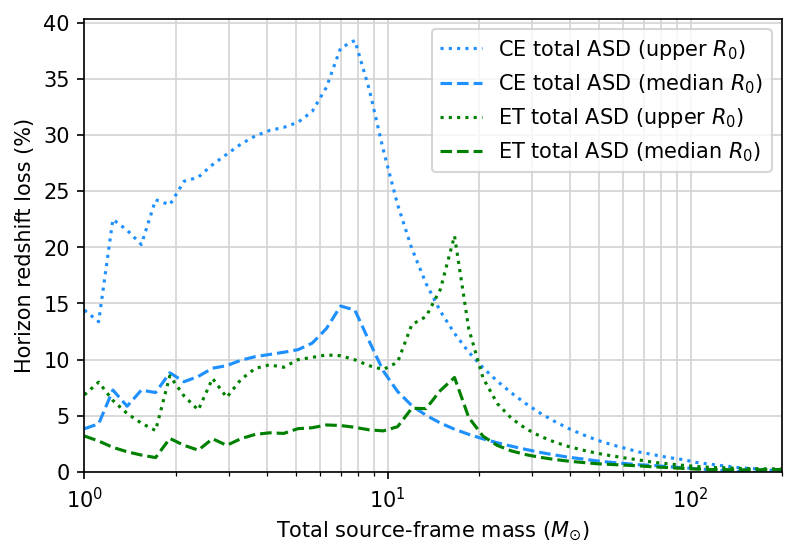

In [4]:
horizon_loss_medianrate_CE = np.array(horizon_redshift_total_medianrate_CE)/np.array(horizon_redshift_design_CE)
horizon_loss_medianrate_ET = np.array(horizon_redshift_total_medianrate_ET)/np.array(horizon_redshift_design_ET)

plt.figure(dpi=150)
plt.semilogx(total_mass, 100*(np.ones(len(horizon_loss_CE))-horizon_loss_CE), label=r'CE total ASD (upper $R_0$)', color='dodgerblue', linestyle='dotted')
plt.semilogx(total_mass, 100*(np.ones(len(horizon_loss_medianrate_CE))-horizon_loss_medianrate_CE), label=r'CE total ASD (median $R_0$)', color='dodgerblue', linestyle='dashed')
plt.semilogx(total_mass, 100*(np.ones(len(horizon_loss_ET))-horizon_loss_ET), label=r'ET total ASD (upper $R_0$)', color='green', linestyle='dotted')
plt.semilogx(total_mass, 100*(np.ones(len(horizon_loss_medianrate_ET))-horizon_loss_medianrate_ET), label=r'ET total ASD (median $R_0$)', color='green', linestyle='dashed')

plt.xlim(total_mass[0], total_mass[-1])
plt.xlabel(r"Total source-frame mass ($M_{\odot}$)")
plt.ylabel("Horizon redshift loss (%)")
plt.ylim(0,)
plt.legend()
plt.grid(which='both', color='lightgray')
plt.savefig('horizon_redshift_loss_CE_ET_sourceframe_totM_IMRPhenomD.png', dpi=500)
plt.savefig('horizon_redshift_loss_CE_ET_sourceframe_totM_IMRPhenomD.pdf', dpi=500)
plt.show()

/tmp/ipykernel_754/3975858261.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


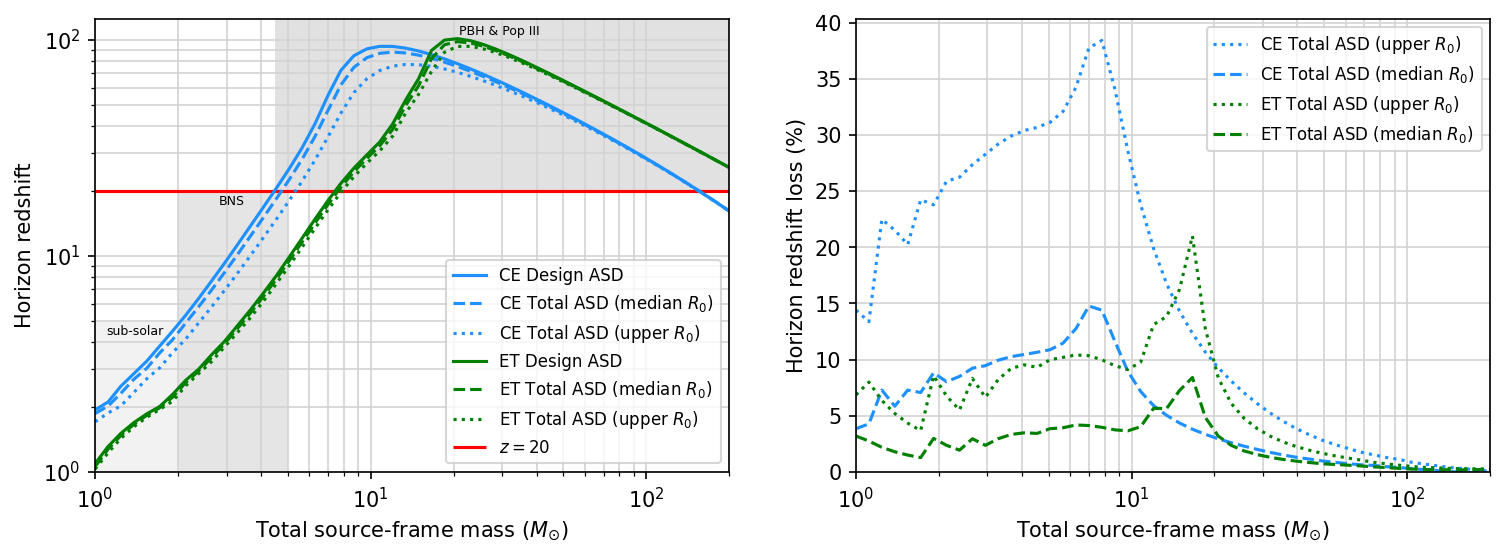

In [5]:
# plot these two together

f = plt.figure(figsize=(12,4), dpi=150)
plt.rc('legend', fontsize=8)
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hlines(y=20, xmin=total_mass[0], xmax=total_mass[-1], colors='red', linestyles='solid', label=r'$z=20$')

ax1.loglog(total_mass, horizon_redshift_design_CE, label='CE Design ASD', color='dodgerblue', linestyle='solid')
ax1.loglog(total_mass, horizon_redshift_total_medianrate_CE, label=r'CE Total ASD (median $R_0$)', color='dodgerblue', linestyle='dashed')
ax1.loglog(total_mass, horizon_redshift_total_upperrate_CE, label=r'CE Total ASD (upper $R_0$)', color='dodgerblue', linestyle='dotted')
ax1.loglog(total_mass, horizon_redshift_design_ET, label='ET Design ASD', color='green', linestyle='solid')
ax1.loglog(total_mass, horizon_redshift_total_medianrate_ET, label=r'ET Total ASD (median $R_0$)', color='green', linestyle='dashed')
ax1.loglog(total_mass, horizon_redshift_total_upperrate_ET, label=r'ET Total ASD (upper $R_0$)', color='green', linestyle='dotted')
ax1.fill([1, 2, 2, 1], [1, 1, 5, 5], 'silver', alpha=0.2)
ax1.text(1.1, 4.3, "sub-solar", fontsize=6)
ax1.fill([2, 5, 5, 2], [1, 1, 20, 20], 'gray', alpha=0.2)
ax1.text(2.8, 17.2, "BNS", fontsize=6)
ax1.fill([4.5, total_mass[-1], total_mass[-1], 4.5], [20, 20, 125, 125], 'dimgray', alpha=0.2)
ax1.text(21, 105, "PBH & Pop III", fontsize=6)
ax1.set_xlabel(r"Total source-frame mass ($M_{\odot}$)")
ax1.set_ylabel("Horizon redshift")
ax1.set_xlim(total_mass[0], total_mass[-1])
ax1.set_ylim(1, 125)
ax1.legend()
ax1.grid(which='both', color='lightgray')

ax2.semilogx(total_mass, 100*(np.ones(len(horizon_loss_CE))-horizon_loss_CE), label=r'CE Total ASD (upper $R_0$)', color='dodgerblue', linestyle='dotted')
ax2.semilogx(total_mass, 100*(np.ones(len(horizon_loss_medianrate_CE))-horizon_loss_medianrate_CE), label=r'CE Total ASD (median $R_0$)', color='dodgerblue', linestyle='dashed')
ax2.semilogx(total_mass, 100*(np.ones(len(horizon_loss_ET))-horizon_loss_ET), label=r'ET Total ASD (upper $R_0$)', color='green', linestyle='dotted')
ax2.semilogx(total_mass, 100*(np.ones(len(horizon_loss_medianrate_ET))-horizon_loss_medianrate_ET), label=r'ET Total ASD (median $R_0$)', color='green', linestyle='dashed')

ax2.set_xlim(total_mass[0], total_mass[-1])
ax2.set_xlabel(r"Total source-frame mass ($M_{\odot}$)")
ax2.set_ylabel("Horizon redshift loss (%)")
ax2.set_ylim(0,)
ax2.legend()
ax2.grid(which='both', color='lightgray')
f.savefig('horizon_redshift_loss_ratio_CE_ET_sourceframe_totM_IMRPhenomD.png', dpi=500)
f.savefig('horizon_redshift_loss_ratio_CE_ET_sourceframe_totM_IMRPhenomD.pdf', dpi=500)
f.show()